In [102]:
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')

from statsmodels.graphics.correlation import plot_corr
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix

In [70]:
dataset = pd.read_csv('pokemon.csv')

In [71]:
dataset.head()

,#,Name,Type,Type2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [72]:
#Odstránime nepotrebné údaje
del dataset['#']
del dataset['Type2']
del dataset['Name']
del dataset['Total']

In [73]:
dataset.describe()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [74]:
corrMatrix = dataset.corr( method = 'pearson') #Korelačná metóda pearson využíva štandardný korelačný koeficient.
corrMatrix

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
HP,1.000000,0.422386,0.239622,0.362380,0.378718,0.175952,0.058683,0.273620
Attack,0.422386,1.000000,0.438687,0.396362,0.263990,0.381240,0.051451,0.345408
Defense,0.239622,0.438687,1.000000,0.223549,0.510747,0.015227,0.042419,0.246377
Sp. Atk,0.362380,0.396362,0.223549,1.000000,0.506121,0.473018,0.036437,0.448907
Sp. Def,0.378718,0.263990,0.510747,0.506121,1.000000,0.259133,0.028486,0.363937
Speed,0.175952,0.381240,0.015227,0.473018,0.259133,1.000000,-0.023121,0.326715
Generation,0.058683,0.051451,0.042419,0.036437,0.028486,-0.023121,1.000000,0.079794
Legendary,0.273620,0.345408,0.246377,0.448907,0.363937,0.326715,0.079794,1.000000


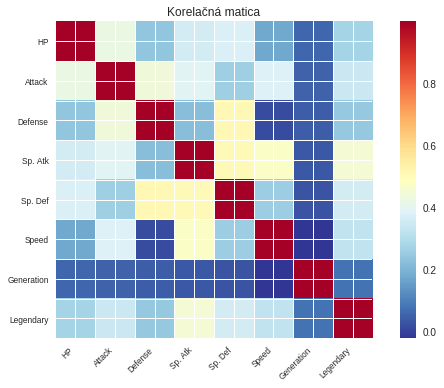

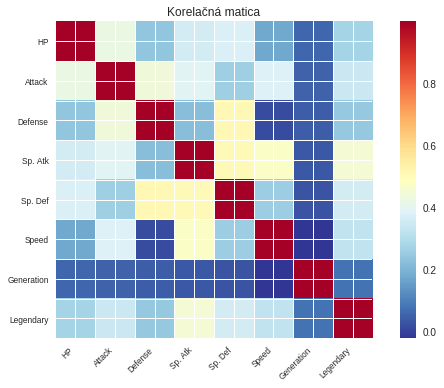

In [75]:
#Môžeme vidieť miernu koreláciu medzi legendárnymi pokémonmi a rýchlosťou útoku/obrany, a rýchlosťou.
plot_corr(corrMatrix, xnames=corrMatrix.columns, ynames=corrMatrix.columns, title='Korelačná matica', cmap='RdYlBu_r')

In [76]:
#Vidíme, že dataset nie je vybalancovaný a existuje veľké množstvo nelegendárnych pokémonov oproti legendárnym.
dataset.Legendary.value_counts()

False    735
True      65
Name: Legendary, dtype: int64

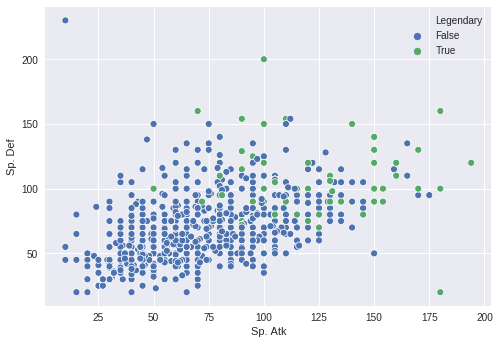

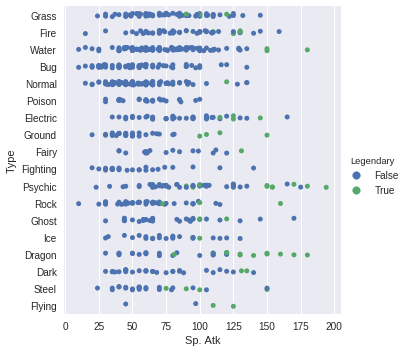

In [83]:
sns.scatterplot(x='Sp. Atk', y='Sp. Def', data=dataset,hue="Legendary")
sns.catplot(x='Sp. Atk', y='Type', data=dataset,hue="Legendary")


In [86]:
dataset = dataset.drop('Type',axis=1)

scaler = StandardScaler()
scaler.fit(dataset.drop('Legendary',axis=1))
scaled_dataset = scaler.transform(dataset.drop('Legendary',axis=1))

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


In [87]:
X_train, X_test, y_train, y_test = train_test_split(scaled_dataset,dataset['Legendary'],test_size=0.30)

In [112]:
MLPC = MLPClassifier(alpha=0.01, hidden_layer_sizes=(1,1), max_iter=100)
MLPC.fit(X_train, y_train)
MLPC.score(X_test, y_test)
#Môžeme vidieť, že pomocou viac vrstvového perceptronu dosahujeme (iba jedna vrstva a jeden neuron) vysokú úspešnosť

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.9291666666666667

In [113]:
#avšak dôvodom je vysoký počet nelegendárnych pokémonov a úspešnosť odhadu legendárnych pokémonov je 0%
#v ďalšej verzií je teda nutné zmeniť vnútornú vrstvu

prediction = MLPC.predict(X_test)
confusion_matrix(y_test,prediction)

array([[223,   0],
       [ 17,   0]])

In [114]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

       False       0.93      1.00      0.96       223
        True       0.00      0.00      0.00        17

   micro avg       0.93      0.93      0.93       240
   macro avg       0.46      0.50      0.48       240
weighted avg       0.86      0.93      0.90       240



/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
